<a href="https://colab.research.google.com/github/Pratyushk2003/self-reformer/blob/main/selfreformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install importlib
!pip install timm

  Preparing metadata (setup.py) ... done
  Created wheel for importlib: filename=importlib-1.0.4-py3-none-any.whl size=5851 sha256=6e24dae8d6b74af38b6e78a983db984187b3b4a90024fca44df837b583dbdf64
  Stored in directory: /root/.cache/pip/wheels/0f/77/67/b2657372b2523148d81dcdd875916a417f047849169567cb2e
Successfully built importlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import matplotlib.pyplot as plt

In [4]:
!git clone https://github.com/BarCodeReader/SelfReformer.git

Cloning into 'SelfReformer'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 79 (delta 29), reused 30 (delta 2), pack-reused 0
Receiving objects: 100% (79/79), 2.95 MiB | 16.16 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [5]:
%cd SelfReformer

/content/SelfReformer


In [6]:
class Options(object):
    def __init__(self, seed, pretrain, model, GPU_ID, pvt_path, dataset_root, dataset, test_dataset, lr, decay_step, img_size, batch_size, max_epoch, num_workers, gclip, lmbda, test_only, random_seed, save_every_ckpt, save_result, save_all, ckpt_root, save_root, save_msg, transformer):
        self.seed = seed
        self.pretrain = pretrain
        self.model = model
        self.GPU_ID = GPU_ID
        self.pvt_path = pvt_path
        self.dataset_root = dataset_root
        self.dataset = dataset
        self.test_dataset = test_dataset
        self.lr = lr
        self.decay_step = decay_step
        self.img_size = img_size
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.num_worker = num_workers
        self.gclip = gclip
        self.lmbda = lmbda
        self.test_only = test_only
        self.random_seed = random_seed
        self.save_every_ckpt = save_every_ckpt
        self.save_result = save_result
        self.save_all = save_all
        self.ckpt_root = ckpt_root
        self.save_root = save_root
        self.save_msg = save_msg
        self.transformer= transformer





In [54]:
import numpy as np
import cv2
import importlib
import os
import skimage.io as io
import torch
import torch.nn.functional as F
from SelfReformer.augments import Augment
from SelfReformer.option import get_option
from SelfReformer.utils import LogWritter

opt = Options(1, "", "network", 0, "/content/drive/My Drive/best_DUTS-TE.pt", "../dataset/", "DUTSTR", "benchmark_DUTSTE", 1e-4, 40, 224, 16, 200, 8, 0, 5, "", "store_true", "store_true", "store_true", "store_true", "./ckpt", "./output", "abc", [[2, 1, 512, 3, 49],
                           [2, 1, 320, 3, 196],
                           [2, 1, 128, 3, 784],
                           [2, 1, 64, 3, 3136]])
torch.manual_seed(opt.seed)
module = importlib.import_module("model.{}".format(opt.model.lower()))
logger = LogWritter(opt)
dev =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = module.Net(opt)
net = net.to(dev)
msg = "# params:{}\n".format(
sum(map(lambda x: x.numel(), net.parameters())))
aug = Augment(opt)
if opt.save_result:
    save_root = os.path.join(opt.save_root, opt.save_msg)
    os.makedirs(save_root, exist_ok=True)

path = '/content/drive/My Drive/best_DUTS-TE.pt'
print('loading model from: {}'.format(path))
state_dict = torch.load(path, map_location=lambda storage, loc: storage)
net.load_state_dict(state_dict)

loading model from: /content/drive/My Drive/best_DUTS-TE.pt


<All keys matched successfully>

In [127]:
url = '/content/Chicken parm_1.png'

In [128]:
IMG = cv2.imread(url)
IMG = aug.resize(IMG)
IMG = np.ascontiguousarray(IMG.transpose((2, 0, 1)))
IMG = aug.norm(aug.to_tensor(IMG) / 255.)
IMG = np.expand_dims(IMG, axis=0)
b, c, h, w = IMG.shape

IMG = torch.from_numpy(IMG).to(dev)
pred = net(IMG)

pred_sal = F.pixel_shuffle(pred[-1], 4)
pred_sal = F.interpolate(pred_sal, (h,w), mode='bilinear', align_corners=False)
pred_sal = torch.sigmoid(pred_sal).squeeze()
pred_sal = (pred_sal * 255.).detach().cpu().numpy().astype('uint8')

matt_img = pred[0].repeat(1,256,1,1)
matt_img = F.pixel_shuffle(matt_img, 16)
matt_img = F.interpolate(matt_img, (h,w), mode='bilinear', align_corners=False)
matt_img = torch.sigmoid(matt_img)
matt_img = (matt_img*255.).squeeze().detach().cpu().numpy().astype('uint8')



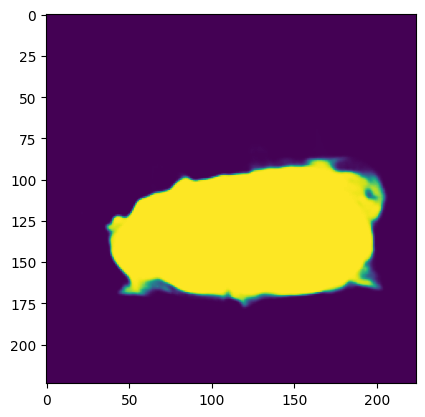

In [129]:
plt.imshow(pred_sal)

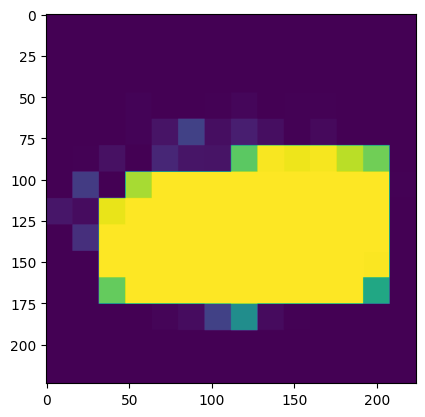

In [130]:
plt.imshow(matt_img)

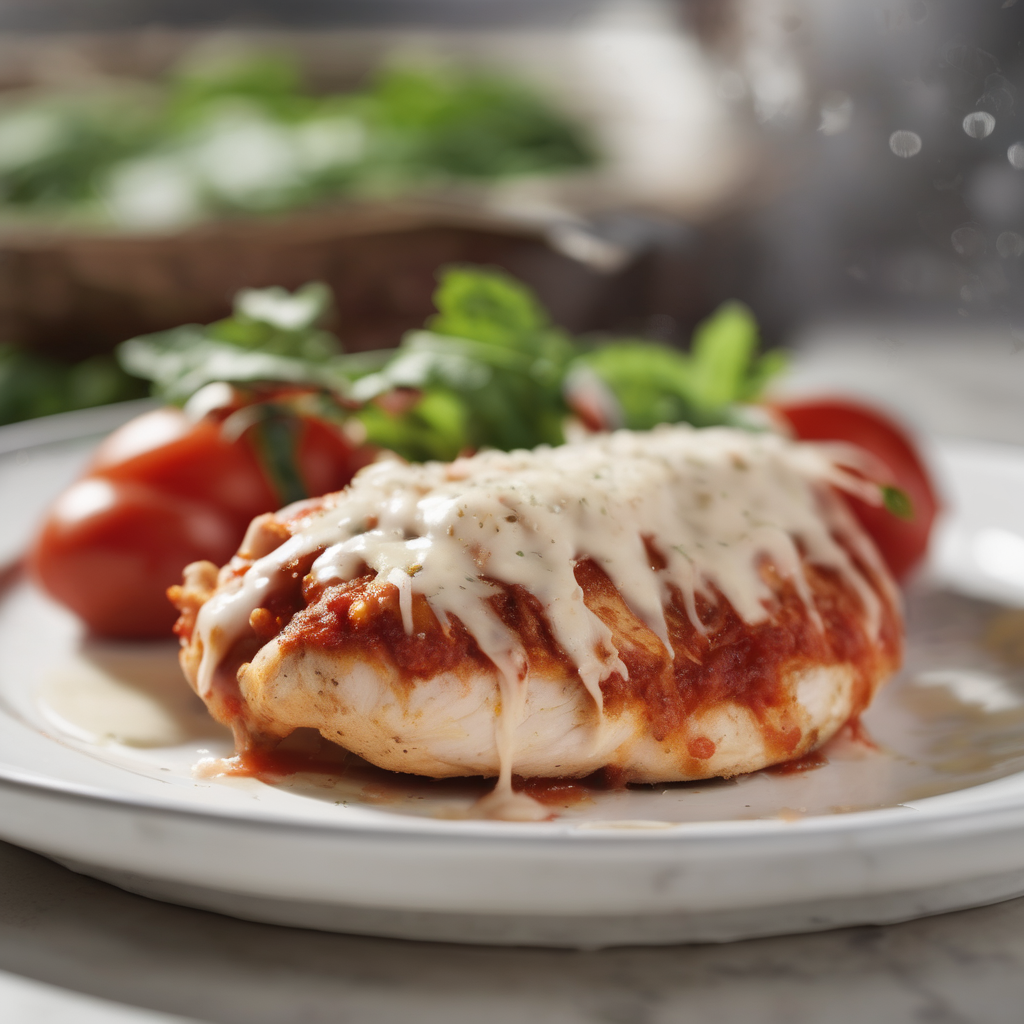

In [131]:
from PIL import Image
y = Image.open(url)
y